In [2]:
import MDAnalysis as mda
import matplotlib.pyplot as plt
import numpy as np
import os

d:\all_programming\MSD\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
cwd = os.getcwd()
cwd = cwd.replace('msd_water_box',r"data_files\unwrapped")

graphite_water_psf = cwd + r'\graphite_water.psf'
graphite_trajectory_dcd = cwd + r'\output_per_20ps.dcd'

global_uni = mda.Universe(graphite_water_psf,graphite_trajectory_dcd)
Oxg_uni = global_uni.select_atoms('resname SPCE and name OW')
# Importing data

In [3]:
def plot_dict(data):
    # Number of keys in the dictionary
    num_keys = len(data)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(num_keys, 1, figsize=(8, num_keys * 4))
    
    # If there's only one subplot, axes is not a list, so we need to make it a list
    if num_keys == 1:
        axes = [axes]
    
    # Loop through each key in the dictionary
    for i, key in enumerate(data):
        x_vals = range(len(data[key]))
        y_vals = data[key]
        
        # Plot the data
        axes[i].plot(x_vals, y_vals, marker='o')
        axes[i].set_title(f'Plot between partition {key}-{key + 1}')
        axes[i].set_xlabel('Time (ps)')
        axes[i].set_ylabel('Average MSD (Å²)')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


In [4]:
def calculate_msd(position_dict):
    x_vals = np.array(position_dict['x_vals'])
    y_vals = np.array(position_dict['y_vals'])
    z_vals = np.array(position_dict['z_vals'])
    num_points = len(x_vals)
    msd = np.zeros(num_points)
    for dt in range(1, num_points):
        displacements = np.square(x_vals[dt:] - x_vals[:-dt]) + np.square(y_vals[dt:] - y_vals[:-dt]) + np.square(z_vals[dt:] - z_vals[:-dt])
        msd[dt] = np.mean(displacements)
    return msd

In [5]:
def matrix_addition(array1, array2):
    if len(array1) > len(array2):
        array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
    else:
        array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
    return array1 + array2

In [6]:
partition_height = 65
partition_cuts = 4
partition = []

for i in range(partition_cuts):
    partition.append(65 * ( (i + 1) / partition_cuts))

In [7]:
position_dict = {}
msd_dict = {}

for i in range(partition_cuts):
    msd_dict[i] = {}

for atom_num in range(len(Oxg_uni)):
    position_dict[atom_num] = {'location':'DNE','x_vals':[],'y_vals':[],'z_vals':[]}

    for frame in range(len(global_uni.trajectory)):
        global_uni.trajectory[frame]
        oxg_pos = Oxg_uni.positions
        wanted_atom_pos = oxg_pos[atom_num]
        current_z = wanted_atom_pos[2]

        for i in range(len(partition)):
            if current_z < partition[i]:
                current_part = i
                break


        if frame == 0:
            position_dict[atom_num]['location'] = current_part
        if frame != 0 and position_dict[atom_num]['location'] != current_part:
            break

        position_dict[atom_num]['x_vals'].append(wanted_atom_pos[0])
        position_dict[atom_num]['y_vals'].append(wanted_atom_pos[1])
        position_dict[atom_num]['z_vals'].append(wanted_atom_pos[2])

    individual_msd = calculate_msd(position_dict[atom_num])
    msd_dict[position_dict[atom_num]['location']][atom_num] = [individual_msd, len(individual_msd)]

In [8]:
len_count = {}
msd_len = {}

for key in msd_dict.keys():
    len_count[key] = {}
    msd_len[key] = []

    for atom_num in msd_dict[key].keys():
        msd_len[key].append(msd_dict[key][atom_num][1])

for i in range(partition_cuts):
    for j in range(1, max(msd_len[i]) + 1):
        len_count[i][j] = 0

for key in len_count.keys():
    for item in msd_len[key]:
        for i in range(1, item + 1):
            len_count[key][i] += 1

In [9]:
msd_summed_dict = {}

for key in msd_dict.keys():
    msd_summed_dict[key] = []

    for atom_num in msd_dict[key].keys():
        msd_summed_dict[key] = matrix_addition(msd_dict[key][atom_num][0],msd_summed_dict[key])

In [10]:
averaged_msd = {}

for key in msd_summed_dict.keys():
    averaged_msd[key] = []
    for i in range(len(msd_summed_dict[key])):
        averaged_msd[key].append(msd_summed_dict[key][i] / len_count[key][i + 1])

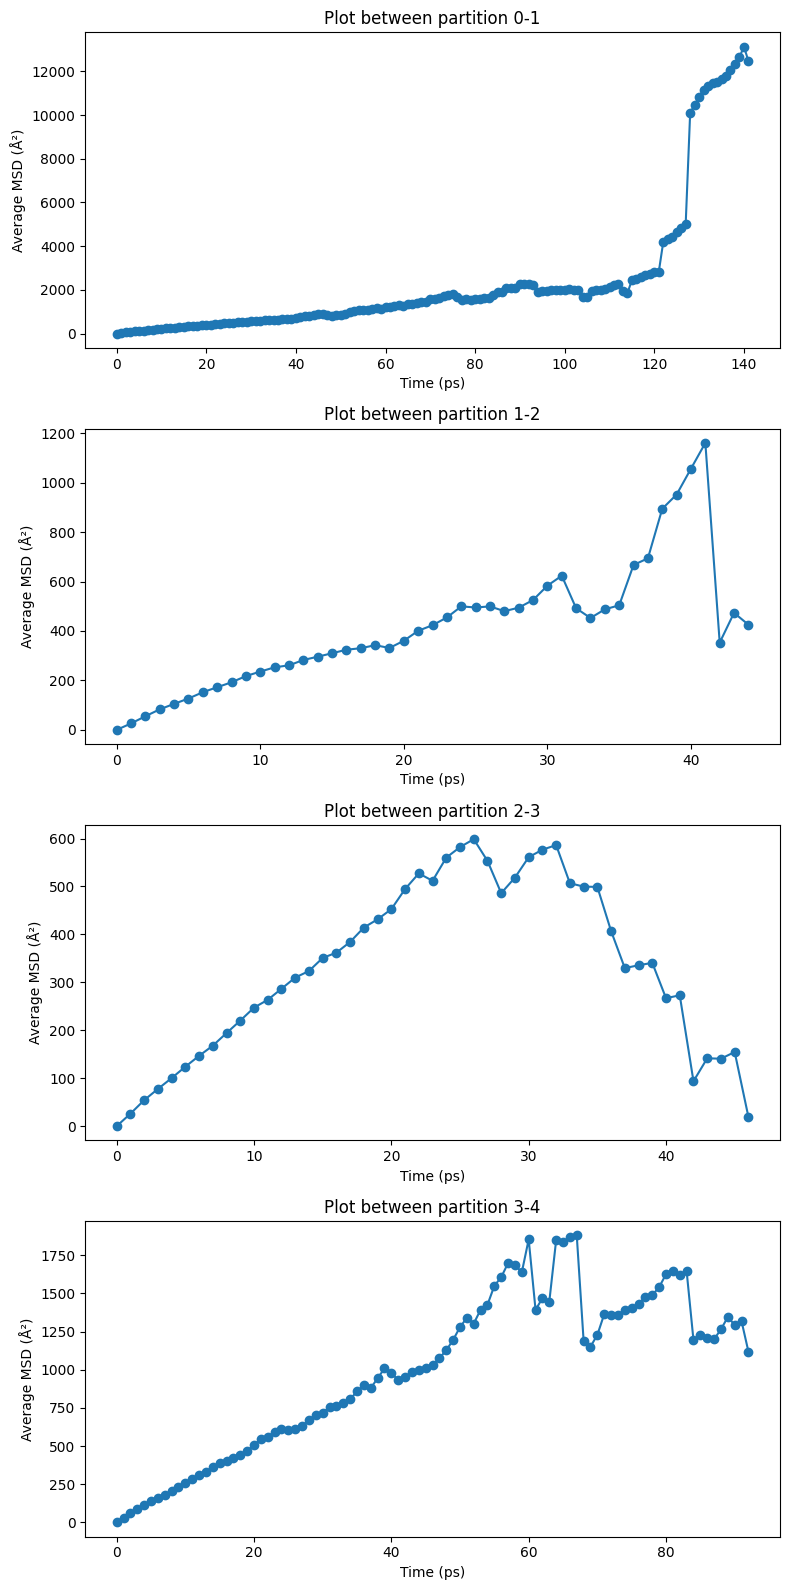

In [11]:
plot_dict(averaged_msd)